In [1]:
# angle based method. uses angle between vectors 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
# file information
header=['id','time_1','lat_1','long_1','heading','speed','consumer_id1','system_time1','x','y','local_time_1',
      'id2','time_2','lat_2','long_2','heading_2','speed_2','consumer_id2','system_time2','x2','y2','local_time_2',
      'speed_m','acceleration']
data_dir = '../step_014_probe_add_segment_speed_and_acceleration'


In [3]:
# store filenames in the given data_dir
name_list=[]
for folder in os.listdir(data_dir):
    file_dir = os.path.join(data_dir, folder)
    file_name = list(filter(lambda x: 'csv' in x, os.listdir(file_dir)))[0]
    file_loc = os.path.join(file_dir, file_name)
    name_list.append(file_loc)

In [18]:
# helper functions

def trajectory_from_table(df):
# return a list of probe points for one csv file
    trajectories = []
    for index, row in df.iterrows():
        trajectories.append([row['local_time_1'],row['x'],row['y'],row['speed']])
    return trajectories

In [ ]:
def normalize_trajectory(t):
# return a normalizes trajectory
    SCALE_DISTANCE = 1
    SCALE_SPEED = 70

    def kmph_to_mph(speed):
        return speed/1.609

    def norm_speed(speed):
        return speed/SCALE_SPEED

    def norm_distance(distance):
        return distance/SCALE_DISTANCE
    
    def get_seconds(t):
        import datetime
        import time
        x=time.strptime(t[11:19],'%H:%M:%S')
        return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
    
    t_=[]
    if len(t)>0:
        start_time = get_seconds(t[0][0])
        start_x = t[0][1]
        start_y = t[0][2]
    for i in range(len(t)):
        t_.append([norm_distance(t[i][1]-start_x),norm_distance(t[i][2]-start_y),norm_speed(kmph_to_mph(t[i][3])),get_seconds(t[i][0])])
    return t_

In [ ]:
def find_turns(trajectory, min_angle = np.pi / 4):
    # Define a minimum angle to treat change in direction
    # as significant (valuable turning point).
    
    def angle(directions):
        """Return the angle between vectors
        """
        vec2 = directions[1:]
        vec1 = directions[:-1]

        norm1 = np.sqrt((vec1 ** 2).sum(axis=1))
        norm2 = np.sqrt((vec2 ** 2).sum(axis=1))
        cos = (vec1 * vec2).sum(axis=1) / (norm1 * norm2)   
        return np.arccos(cos)
    
    trajectory = np.array(trajectory)
    x,y=trajectory[:,0],trajectory[:,1]
    
#  remove speed and other info from trajectories
    trajectory = np.delete(trajectory,2,1)

#     smoothen trajectories if required
    from rdp import rdp    
    simplified_trajectory = rdp(trajectory, epsilon=10)
    sx, sy = simplified_trajectory.T

   
    # Compute the direction vectors on the simplified_trajectory.
    directions = np.diff(simplified_trajectory, axis=0)
#     get angles from direction vectors
    theta = angle(directions)

    # Select the index of the points with the greatest theta.
    # Large theta is associated with greatest change in direction.
    idx = np.where(theta > min_angle)[0] + 1
    
    # classify Left or right turn
    idx_l = []
    idx_r = []
    for i in idx:
        a_x,a_y=directions[i-1]
        b_x,b_y=directions[i]
        if (a_x*b_y>a_y*b_x):
            idx_l.append(i)
        else:
            idx_r.append(i)
    
    # Visualize valuable turning points on the simplified trjectory.
    if len(sx)>5:
        print (np.diff(t_))
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x, y, 'r--', label='trajectory')
        ax.plot(sx, sy, 'bx-', label='simple')
        ax.plot(sx[idx_l], sy[idx_l], 'ro', markersize = 7, label='left turn')
        ax.plot(sx[idx_r], sy[idx_r], 'go', markersize = 7, label='right turn')
        ax.plot(0,0,'ko',markersize=7, label = 'start')
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plt.legend()

In [11]:
# test small batches so easier to visualize
def process_trajectory_batch(start,end):
    for i in range(start,end):
        df = pd.read_csv(name_list[i],header=None)
        df.columns = header
        find_turns(normalize_trajectory(trajectory_from_table(df)))

[ 61.  61.  60.  61. 122.]
[  5.   1.  84.  89.  91.  90. 107.  90.  87.  60.  90.  90.  90.  59.
  91.  90.  90.  90.  90.  90.  89.  91.  90.  90.  90.  90.  90.  89.
  91.  90.  90.  90.   9.]


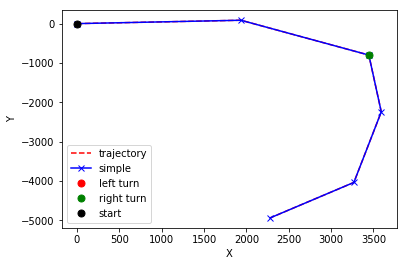

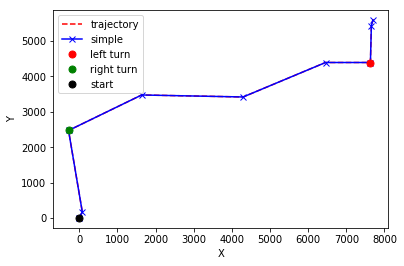

In [23]:
# test
process_trajectory_batch(0,15)